In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import time, copy
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import pandas as pd

In [2]:
print("PyTorch CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected by PyTorch.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used:", device)

PyTorch CUDA version: 12.1
CUDA available: True
GPU Name: NVIDIA GeForce MX350
Device used: cuda


In [3]:
base_dir = r"C:\Users\user\Desktop\DL"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Data transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # randomly flip images horizontally to improve generalization
    transforms.RandomRotation(20), # randomly rotate images by up to 20 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), # randomly change brightness, contrast, saturation
    transforms.ToTensor(), # convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], # normalize with mean and std for pre-trained models to understand
                         [0.229, 0.224, 0.225])
])

# Validation and Test transforms for no randomness, cvonsistent evaluation
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
# datasets.ImageFolder automatically labels images based on subfolder names.
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

class_names = train_dataset.classes

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True) # shuffle for training to improve generalization, randomize order each epoch
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True) # num_workers=2 for parallel data loading
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Class info
num_classes = len(class_names)
print(f"Classes ({num_classes}):", class_names)
print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))

Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648
Val size: 1327
Test size: 1337


In [4]:
if isinstance(train_dataset, torch.utils.data.Subset):
    # For Subset, use the original dataset and indices
    labels = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]
else:
    labels = [y for _, y in train_dataset.samples]

# Compute class counts
counts = Counter(labels)
counts_list = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts_list)

# Compute class weights (inverse frequency), minority classes get more importance during training.
class_weights = torch.tensor([sum(counts_list)/c for c in counts_list], dtype=torch.float).to(device)
print("Class weights:", class_weights)

# Define weighted CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [5]:
# load pretrained ResNet-50
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# unfreeze only the last block (layer4) and the final fully connected layer
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# replace the final fully connected layer to match my number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# move model to device (GPU if available)
model = model.to(device)

# print trainable layers
trainable_layers = [name for name, param in model.named_parameters() if param.requires_grad]
print("Trainable layers:")
for layer in trainable_layers:
    print("  ", layer)

print(f"\nTotal trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable layers:
   layer4.0.conv1.weight
   layer4.0.bn1.weight
   layer4.0.bn1.bias
   layer4.0.conv2.weight
   layer4.0.bn2.weight
   layer4.0.bn2.bias
   layer4.0.conv3.weight
   layer4.0.bn3.weight
   layer4.0.bn3.bias
   layer4.0.downsample.0.weight
   layer4.0.downsample.1.weight
   layer4.0.downsample.1.bias
   layer4.1.conv1.weight
   layer4.1.bn1.weight
   layer4.1.bn1.bias
   layer4.1.conv2.weight
   layer4.1.bn2.weight
   layer4.1.bn2.bias
   layer4.1.conv3.weight
   layer4.1.bn3.weight
   layer4.1.bn3.bias
   layer4.2.conv1.weight
   layer4.2.bn1.weight
   layer4.2.bn1.bias
   layer4.2.conv2.weight
   layer4.2.bn2.weight
   layer4.2.bn2.bias
   layer4.2.conv3.weight
   layer4.2.bn3.weight
   layer4.2.bn3.bias
   fc.weight
   fc.bias

Total trainable parameters: 14,985,226


In [6]:
# only update trainable parameters layer 4 and the fully connected layer
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,        # Lower LR for fine-tuning pretrained layers
    weight_decay=1e-5
)

# reduce learning rate when validation F1 plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

c:\Users\user\CODING\Skin-Lession-Detection\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, model_name="ResNet50"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)
            epoch_f1 = f1_score(y_true, y_pred, average='macro')

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)

                # Save best model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")

        # Step scheduler using validation F1
        scheduler.step(best_f1)
        print("-"*40)

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val F1: {best_f1:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [14]:
num_epochs = 30
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    model_name="ResNet50_Finetuned"
)


Epoch 1/30
train Loss: 0.3302 Acc: 0.8628 F1: 0.8524
val Loss: 0.2259 Acc: 0.9096 F1: 0.8852
----------------------------------------

Epoch 2/30
train Loss: 0.3021 Acc: 0.8726 F1: 0.8641
val Loss: 0.2012 Acc: 0.9307 F1: 0.9185
----------------------------------------

Epoch 3/30
train Loss: 0.3035 Acc: 0.8697 F1: 0.8645
val Loss: 0.1734 Acc: 0.9427 F1: 0.9218
----------------------------------------

Epoch 4/30
train Loss: 0.3040 Acc: 0.8744 F1: 0.8655
val Loss: 0.2060 Acc: 0.9352 F1: 0.9239
----------------------------------------

Epoch 5/30
train Loss: 0.2858 Acc: 0.8815 F1: 0.8733
val Loss: 0.1729 Acc: 0.9405 F1: 0.9233
----------------------------------------

Epoch 6/30
train Loss: 0.2784 Acc: 0.8878 F1: 0.8798
val Loss: 0.1701 Acc: 0.9488 F1: 0.9347
----------------------------------------

Epoch 7/30
train Loss: 0.2678 Acc: 0.8907 F1: 0.8828
val Loss: 0.1598 Acc: 0.9412 F1: 0.9256
----------------------------------------

Epoch 8/30
train Loss: 0.2737 Acc: 0.8882 F1: 0.8800
v

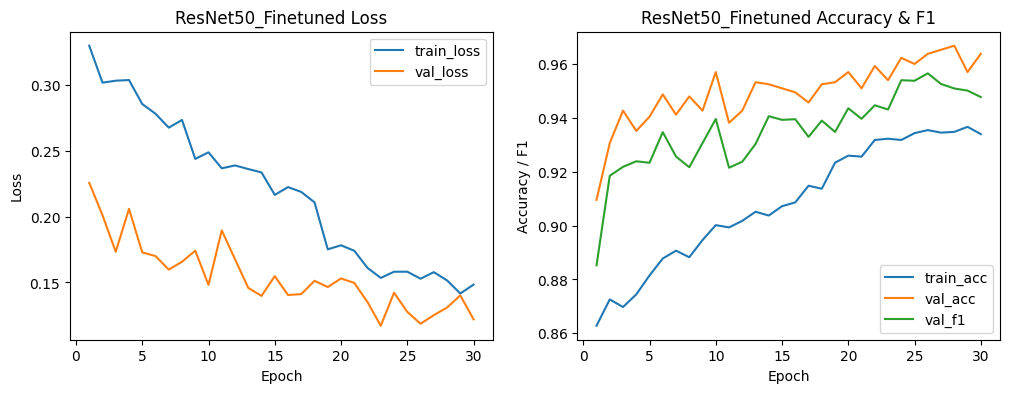

In [15]:
epochs = range(1, len(history["train_loss"]) + 1)
model_name = "ResNet50_Finetuned"

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="train_acc")
plt.plot(epochs, history["val_acc"], label="val_acc")
plt.plot(epochs, history["val_f1"], label="val_f1")  # add validation F1
plt.xlabel("Epoch"); plt.ylabel("Accuracy / F1"); plt.legend(); plt.title(f"{model_name} Accuracy & F1")
plt.show()


In [16]:
# load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

In [17]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.87      0.95      0.91        86
             Chickenpox       0.94      0.96      0.95       112
                 Cowpox       0.99      0.96      0.97        99
         Dermatofibroma       0.96      0.96      0.96        23
                   HFMD       0.96      0.99      0.98       241
                Healthy       0.98      0.98      0.98       171
                Measles       0.98      0.99      0.98        82
              Monkeypox       0.98      0.96      0.97       426
Squamous cell carcinoma       0.93      0.81      0.86        62
       Vascular lesions       1.00      1.00      1.00        25

               accuracy                           0.96      1327
              macro avg       0.96      0.96      0.96      1327
           weighted avg       0.96      0.96      0.96      1327

Confusion matrix:
 [[ 82   0   0   0   0   0   0   0   4   0]
 [  0 108   0   0   0   0

In [18]:
print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# Load best model checkpoint
ckpt_path = "ResNet50_best.pth"
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("Loaded checkpoint:", ckpt_path)
except Exception as e:
    print("Checkpoint load failed (using current model):", e)

model.to(device)
model.eval()  # set to evaluation mode

Test classes order: ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Melanoma', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 2386
Checkpoint load failed (using current model): [Errno 2] No such file or directory: 'ResNet50_best.pth'


C:\Users\user\AppData\Local\Temp\ipykernel_25344\951452986.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
test_dir  = os.path.join(base_dir, "test")
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# DataLoaders
batch_size = 32
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

y_true, y_pred, probs = [], [], []

# Iterate through test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)  # probabilities
        _, preds = torch.max(outputs, 1)    # predicted class

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        probs.extend(ps.cpu().numpy())

# metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.94      0.92        88
             Chickenpox       0.94      0.97      0.96       113
                 Cowpox       0.97      0.98      0.97        99
         Dermatofibroma       1.00      0.76      0.86        25
                   HFMD       0.96      0.99      0.97       242
                Healthy       0.98      0.98      0.98       171
                Measles       0.96      0.98      0.97        83
              Monkeypox       0.99      0.96      0.97       426
Squamous cell carcinoma       0.89      0.88      0.88        64
       Vascular lesions       0.93      1.00      0.96        26

               accuracy                           0.96      1337
              macro avg       0.95      0.94      0.94      1337
           weighted avg       0.96      0.96      0.96      1337




Confusion Matrix:
 [[ 83   0   0   0   0   0   0   0   4   1]
 [  0 110   1   0   0   0   0   2   0   0]
 [  0   1  97   0   0   0   0   1   0   0]
 [  3   0   0  19   0   0   0   0   3   0]
 [  0   0   1   0 239   0   0   2   0   0]
 [  0   0   0   0   3 167   0   1   0   0]
 [  0   1   0   0   1   0  81   0   0   0]
 [  0   5   1   0   7   3   3 407   0   0]
 [  7   0   0   0   0   0   0   0  56   1]
 [  0   0   0   0   0   0   0   0   0  26]]


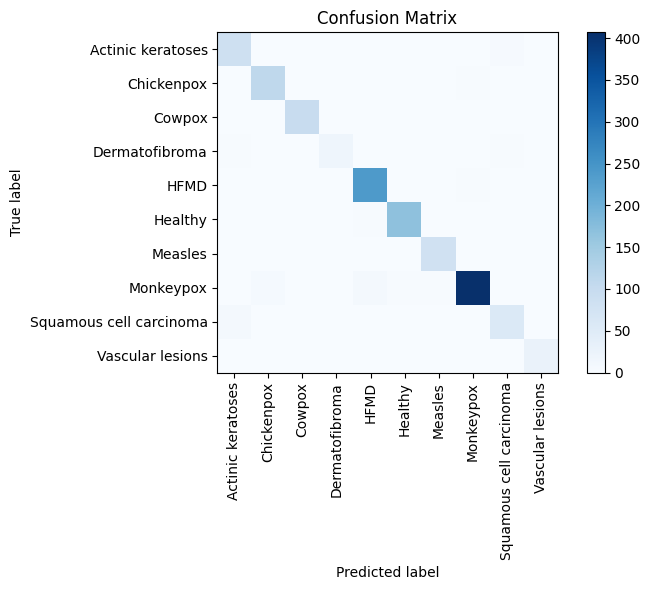

In [20]:
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# plot confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [21]:

# save per-image predictions in to CSV
filenames = [os.path.basename(p[0]) for p in test_dataset.samples]
df = pd.DataFrame({
    "file": filenames,
    "true": [class_names[i] for i in y_true],
    "pred": [class_names[i] for i in y_pred],
    "prob_top": [round(float(np.max(p)),4) for p in probs]
})
df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")

Saved test_predictions.csv


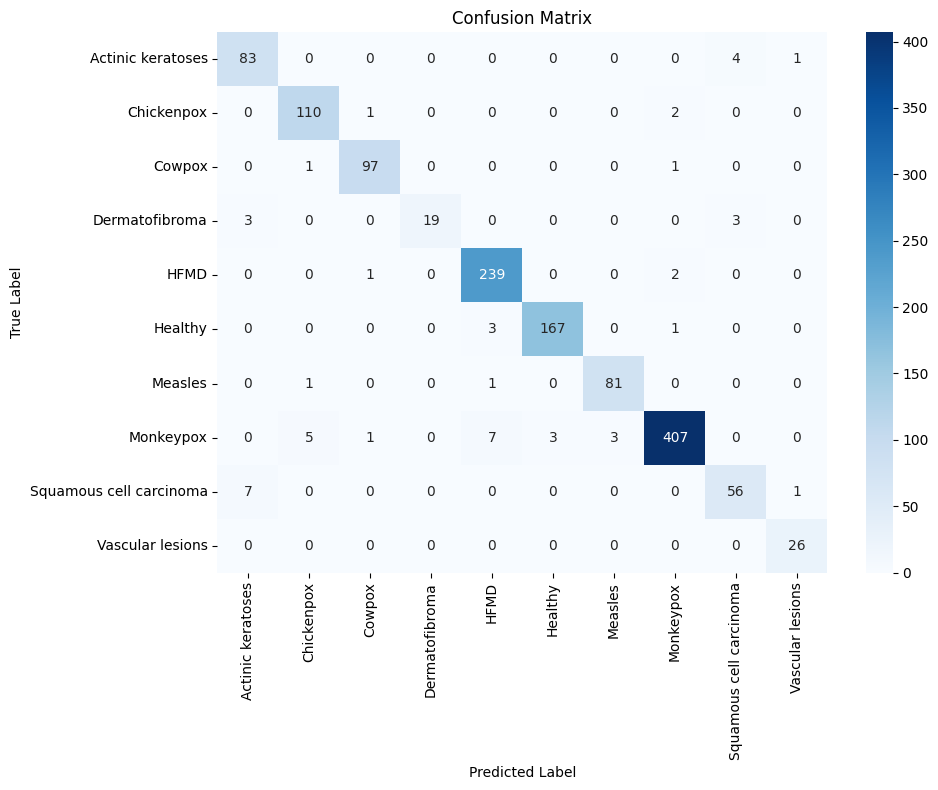

In [22]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [23]:
pd.DataFrame(history).to_csv("training_history.csv", index=False)

In [6]:
# Load best model for inference
model = resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load("ResNet50_Finetuned_best.pth", map_location=device))
model.to(device)
model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_21580\1542041176.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ResNet50_Finetuned_best.pth

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
from PIL import Image
import torch
from torchvision import transforms

image_path = r"C:\Users\user\Desktop\DL\test\Chickenpox\CHP_02_01_1.jpg"

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

image = Image.open(image_path).convert("RGB")  # ensure 3 channels
input_tensor = val_test_transforms(image).unsqueeze(0)  # add batch dimension
input_tensor = input_tensor.to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_class_idx = torch.argmax(probabilities, dim=1).item()

predicted_label = class_names[predicted_class_idx]
confidence = probabilities[0][predicted_class_idx].item()

print(f"Predicted Class: {predicted_label}")
print(f"Confidence: {confidence:.4f}")

Predicted Class: Chickenpox
Confidence: 0.9999


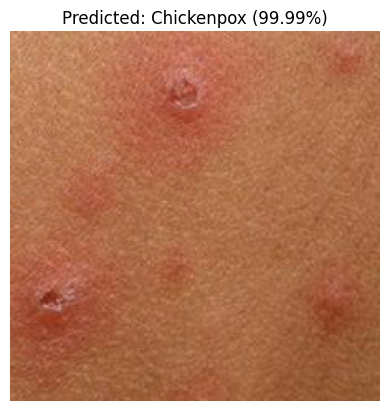

In [8]:
plt.imshow(image)
plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()